In [4]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

In [5]:
x_train = np.empty((0,5))
y_train = np.array([])

with open("Toy Dataset.csv","r") as f:
    d_reader = csv.reader(f,delimiter=",",quotechar="\"")
    first = True
    
    for line in d_reader:
        if first:
            first = False
            continue
        x_train = np.append(x_train,np.array(list(map(int,line[2:7]))).reshape((1,5)),axis=0)
        y_train = np.append(y_train,int(line[8]))
print(x_train.shape)
print(y_train.shape)
# print(y_train)

(419, 5)
(419,)


In [6]:
rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)

x_train, y_train = oversampler.fit_resample(x_train,y_train)

In [7]:
#DecisionTree
random_search_iterations = 1000

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(1, 10), 
    'min_samples_split':uniform(loc=0,scale=1.0)
}
dt = tree.DecisionTreeClassifier()
rscv = RandomizedSearchCV(dt, parameters,cv=10, n_iter=random_search_iterations)
rscv.fit(x_train,y_train)
print("Best Score: {:.4f}".format(rscv.best_score_))
for k,v in rscv.best_params_.items():
    print("{} => {}".format(k,v))
print("Splits: {}".format(rscv.n_splits_))
y_out = rscv.predict(x_train)
print("Accuracy: {:.4f}%".format(np.mean(y_out == y_train) * 100.0))
# print(y_out)

Best Score: 0.3493
criterion => gini
max_depth => 4
min_samples_split => 0.026069461835945273
splitter => random
Splits: 10
Accuracy: 35.6918%


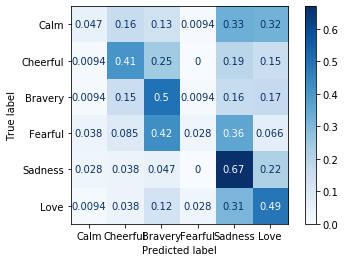

In [8]:
disp = plot_confusion_matrix(rscv, x_train, y_train,
                             display_labels=["Calm","Cheerful","Bravery","Fearful","Sadness","Love"],
                             cmap=plt.cm.Blues,
                             normalize='true')

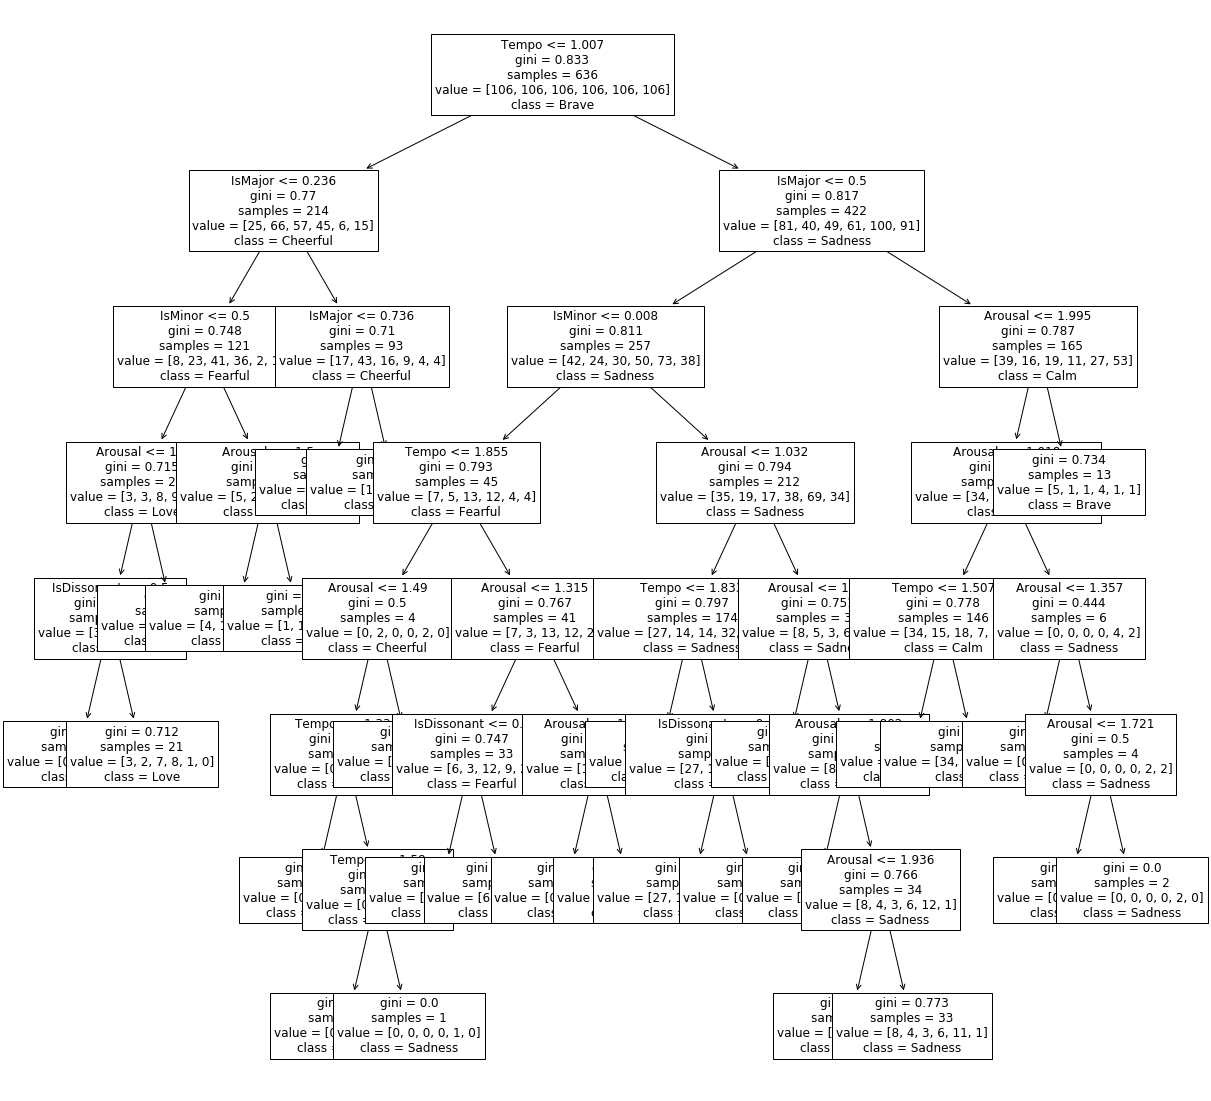

In [9]:
import matplotlib.pyplot as plt

classes = ['Brave', 'Cheerful', 'Fearful', 'Love', 'Sadness', 'Calm']
dt.fit(x_train,y_train)
file = pd.read_csv("Toy Dataset.csv")
features = list(file)
fig, ax = plt.subplots(figsize=(20, 20))
treefig = tree.plot_tree(dt, class_names=classes, feature_names=features[2:7], fontsize=12, ax=ax)
plt.show()

In [9]:
import sklearn
print(sklearn.__version__)

0.22.2.post1
